# Figure 1: CEBRA for consistent and interpretable embeddings
For reference, here is the full figure

![Figure1](https://images.squarespace-cdn.com/content/v1/57f6d51c9f74566f55ecf271/41bfeaca-cfeb-40f5-9335-a4759205f904/fig1grey.png?format=2500w)

#### import plot and data loading dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pprint

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
import numpy as np
import pathlib

In [2]:
data = pd.read_hdf("../data/Figure1.h5", key="data")
synthetic_viz = data["synthetic_viz"]
synthetic_scores = {
    k: data["synthetic_scores"][k] for k in ["cebra", "pivae", "autolfads", "umap", "tsne"]
}
viz = data["visualization"]

## Figure 1b (left):

- True 2D latent (Left). Each point is mapped to spiking rate of 100 neurons, and middle; CEBRA space embedding after linear regression to true latent. Reconstruction score of 100 seeds. Reconstruction score is $R^2$ of linear regression between true latent and resulting embedding from each method. The "behavior label" is a 1D random variable sampled from uniform distribution of [0, $2\pi$] which is assigned to each time bin of synthetic neural data, visualized by the color map.

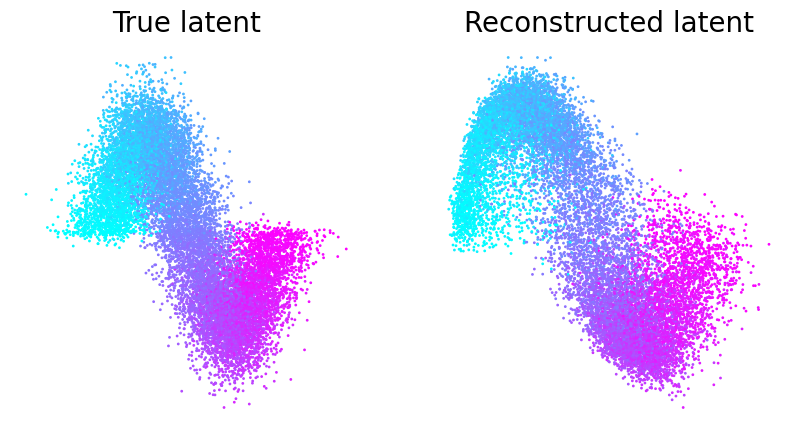

In [3]:
plt.figure(figsize=(10, 5))
ax1 = plt.subplot(121)
ax1.scatter(
    synthetic_viz["true"][:, 0],
    synthetic_viz["true"][:, 1],
    s=1,
    c=synthetic_viz["label"],
    cmap="cool",
)
ax1.axis("off")
ax1.set_title("True latent", fontsize=20)
ax2 = plt.subplot(122)
ax2.axis("off")
ax2.set_title("Reconstructed latent", fontsize=20)
ax2.scatter(
    synthetic_viz["cebra"][:, 0],
    synthetic_viz["cebra"][:, 1],
    s=1,
    c=synthetic_viz["label"],
    cmap="cool",
)

## Figure 1b (right)

- The orange line is median and each black dot is an individual run (n=100). CEBRA-Behavior shows significantly higher reconstruction score compare to pi-VAE, tSNE and UMAP.

/Users/celiabenquet/miniconda/envs/repro/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/var/folders/d7/97cvt_0n63j6tygn4f5mfkzw0000gn/T/ipykernel_75712/3521837284.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


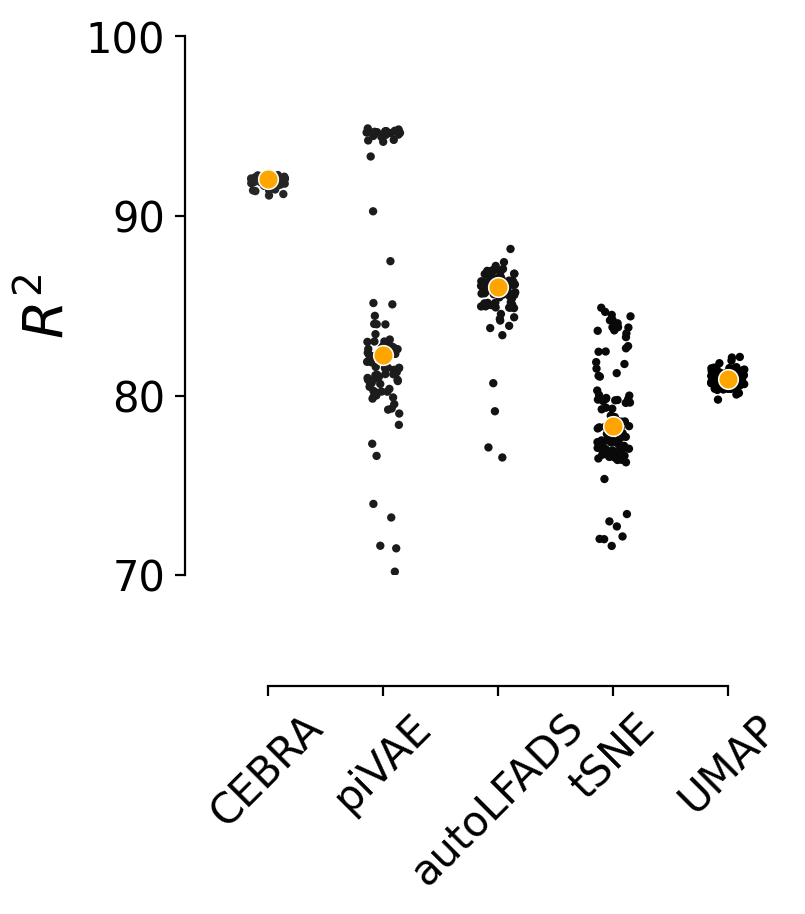

In [4]:
plt.figure(figsize=(3.5, 3.5), dpi = 200)
ax = plt.subplot(111)

keys = ['cebra', 'pivae', 'autolfads', 'tsne', 'umap']
df = pd.DataFrame(synthetic_scores)
sns.stripplot(data=df[keys] * 100, color="black", s=3, zorder=1, jitter=0.15)
sns.scatterplot(data=df[keys].median() * 100, color="orange", s=50)
plt.ylabel("$R^2$", fontsize=20)
plt.yticks(
    np.linspace(0, 100, 11, dtype=int), np.linspace(0, 100, 11, dtype=int), fontsize=20
)
plt.ylim(70, 100)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(axis="both", which="major", labelsize=15)
ax.tick_params(axis = 'x',   rotation = 45)
ax.set_xticklabels(
  ['CEBRA', 'piVAE', 'autoLFADS', 'tSNE', 'UMAP'],
)
sns.despine(
    left=False,
    right=True,
    bottom=False,
    top=True,
    trim=True,
    offset={"bottom": 40, "left": 15},
)
plt.savefig('figure1_synthetic_comparison.png', bbox_inches = "tight", transparent = True)
plt.savefig('figure1_synthetic_comparison.svg', bbox_inches = "tight", transparent = True)

In [5]:
import scipy.stats
from statsmodels.sandbox.stats.multicomp import get_tukey_pvalue
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.oneway import anova_oneway

def anova_with_report(data):
    # One way ANOVA, helper function for formatting
    control = scipy.stats.f_oneway(*data)
    print(control)
    a = anova_oneway(
        data,
        use_var="equal",
    )
    assert np.isclose(a.pvalue, control.pvalue), (a.pvalue, control.pvalue)
    assert np.isclose(a.statistic, control.statistic)
    return f"F = {a.statistic}, p = {a.pvalue}\n\n    " + "\n    ".join(
        str(a).split("\n")
    )
  
print(anova_with_report(synthetic_scores.values()))

F_onewayResult(statistic=251.26683383646048, pvalue=1.1211036071103506e-117)
F = 251.26683383646093, p = 1.121103607110032e-117

    statistic = 251.26683383646093
    pvalue = 1.121103607110032e-117
    df = (4.0, 495.0)
    df_num = 4.0
    df_denom = 495.0
    nobs_t = 500.0
    n_groups = 5
    means = [0.91992909 0.84069867 0.85632795 0.80919274 0.78808936]
    nobs = [100. 100. 100. 100. 100.]
    vars_ = [4.49920142e-06 3.85516265e-03 2.97498646e-04 1.68982912e-05
         9.29583466e-04]
    use_var = equal
    welch_correction = True
    tuple = (251.26683383646093, 1.121103607110032e-117)


In [6]:
_, methods, values = pd.DataFrame(synthetic_scores).stack().reset_index().values.T
values = values.astype(float)
posthoc = pairwise_tukeyhsd(
  endog = np.array(values), groups = np.array(methods).astype(str), alpha = .05
)
print(posthoc)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1  group2 meandiff p-adj   lower   upper  reject
-------------------------------------------------------
autolfads  cebra   0.0636    0.0  0.0512   0.076   True
autolfads  pivae  -0.0156 0.0053  -0.028 -0.0033   True
autolfads   tsne  -0.0682    0.0 -0.0806 -0.0559   True
autolfads   umap  -0.0471    0.0 -0.0595 -0.0348   True
    cebra  pivae  -0.0792    0.0 -0.0916 -0.0669   True
    cebra   tsne  -0.1318    0.0 -0.1442 -0.1195   True
    cebra   umap  -0.1107    0.0 -0.1231 -0.0984   True
    pivae   tsne  -0.0526    0.0  -0.065 -0.0402   True
    pivae   umap  -0.0315    0.0 -0.0439 -0.0191   True
     tsne   umap   0.0211    0.0  0.0087  0.0335   True
-------------------------------------------------------


## Figure 1d

- We benchmarked CEBRA against conv-pi-VAE (both with labels and without (self-supervised mode)), autoLFADS, tSNE, and unsupervised UMAP. Note, for performance against the original pi-VAE see Extended Data Fig. 1. We plot the 3 latents (note, all CEBRA embedding figures show the first 3 latents).

- The dimensionality (D) of the latent space is set to the minimum and equivalent dimension per method (3D for CEBRA and 2D for others) to fairly compare. Note, higher dimensions for CEBRA can give higher consistency values (see Fig. 4).

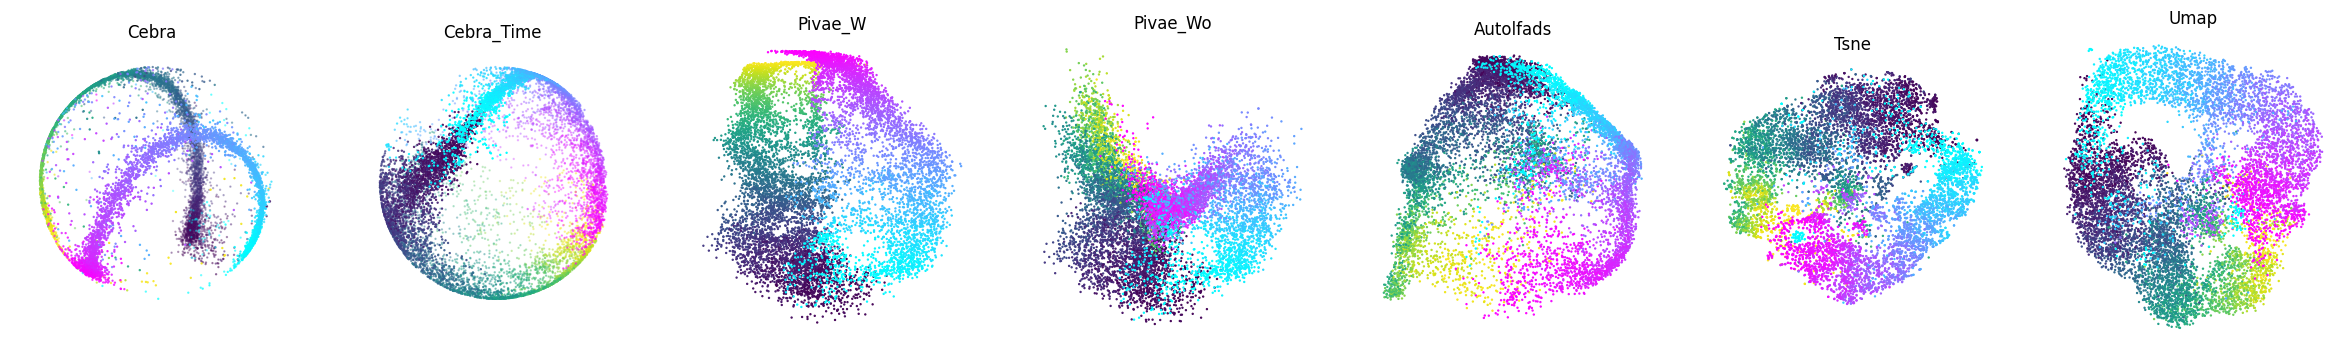

In [7]:
def plot_embedding(ax, i, k, **kwargs):
    fs = viz[k]
    if len(fs) != len(l_ind):
        nan = np.zeros((10, 2)) + float("nan")
        fs = np.concatenate([fs,nan], axis = 0)
    
    if not "cebra" in k:
        ax.scatter(fs[r_ind, 1], fs[r_ind, 0], c=label[r_ind, 0], cmap="viridis", **kwargs)
        ax.scatter(fs[l_ind, 1], fs[l_ind, 0], c=label[l_ind, 0], cmap="cool", **kwargs)
        ax.axis("off")
    else:
        idx = [0,1,2]
        ax.scatter(
            *fs[l_ind][:, idx].T,
            c=label[l_ind, 0],
            cmap="cool",
            **kwargs
        )
        ax.scatter(
            *fs[r_ind][:, idx].T,
            c=label[r_ind, 0],
            cmap="viridis",
            **kwargs
        )
        lim = 0.7
        lim = -lim, lim
        ax.set_xlim(lim)
        ax.set_ylim(lim)
        ax.set_zlim(lim)
        ax.axis("off")
        
    ax.set_aspect("equal")

label = viz["label"]
r_ind = label[:, 1] == 1
l_ind = label[:, 2] == 1

fig = plt.figure(figsize=(30, 5))
for i, k in enumerate(["cebra", "cebra_time", "pivae_w", "pivae_wo", "autolfads", "tsne", "umap"]):
    if "cebra" in k:
      ax = plt.subplot(1, 7, i + 1, projection="3d")
    else:
      ax = plt.subplot(1, 7, i + 1)
    plot_embedding(ax, i, k, s = .5)
    ax.set_title(k.title())
plt.show()

In [8]:
# Uncomment to save the figures individually as high res PNGs:

#label = viz["label"]
#r_ind = label[:, 1] == 1
#l_ind = label[:, 2] == 1
#
#for i, k in enumerate(["autolfads", "umap", "tsne", "pivae_w", "pivae_wo"]): #, "cebra_time", "pivae_w", "pivae_wo", "umap", "tsne"]):
#    fig = plt.figure(figsize=(4, 4), dpi = 1200)
#    ax = plt.gca()
#    #ax = plt.subplot(1, 1, 1, projection="3d")
#    plot_embedding(ax, i, k, s = 5, edgecolor = 'none', alpha = 1)
#    plt.savefig(f'{k}.png', transparent = True, bbox_inches = "tight")
#    plt.show()
#    break

## Figure 1e

- Correlation matrices depict the $R^2$ after fitting a linear model between behavior-aligned embeddings of two animals, one as the target one as the source (mean, n=10 runs). Parameters were picked by optimizing average run consistency across rats.

In [9]:
def recover_python_datatypes(element):
    if isinstance(element, str):
        if element.startswith("[") and element.endswith("]"):
            if "," in element:
                element = np.fromstring(element[1:-1], dtype=float, sep=",")
            else:
                element = np.fromstring(element[1:-1], dtype=float, sep=" ")
    return element


def load_results(result_name):
    """Load a result file.

    The first line in the result files specify the index columns,
    the following lines are a CSV formatted file containing the
    numerical results.
    """
    results = {}
    for result_csv in (ROOT / result_name).glob("*.csv"):
        with open(result_csv) as fh:
            index_names = fh.readline().strip().split(",")
            df = pd.read_csv(fh).set_index(index_names)
            df = df.applymap(recover_python_datatypes)
            results[result_csv.stem] = df
    return results
  
  
ROOT = pathlib.Path("../data")

results = load_results(result_name="results_v3")

result_names = [
    ("cebra-10-b", "CEBRA-Behavior"),
    ("cebra-10-t", "CEBRA-Time"),
    ("pivae-10-w", "conv-piVAE\nw/labels"),
    ("pivae-10-wo", "conv-piVAE"),
    ("autolfads", "autoLFADS"),
    ("tsne", "tSNE"),
    ("umap", "UMAP"),
]

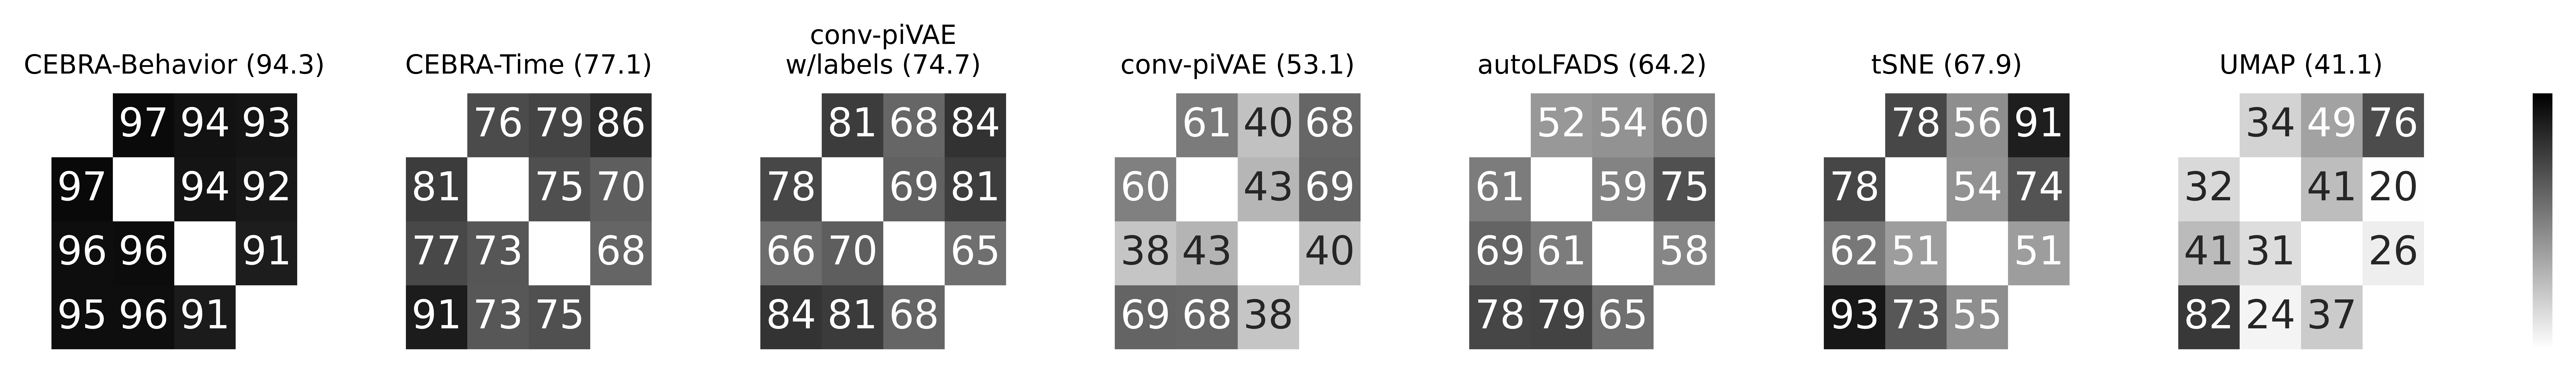

In [10]:
def to_cfm(values):
    values = np.concatenate(values)
    assert len(values) == 12, len(values)
    c = np.zeros((4, 4))
    c[:] = float("nan")
    c[np.eye(4) == 0] = values
    return c

def plot_confusion_matrix(results, name, key, ax, **kwargs):
  if name == "autoLFADS":
    # please see the additional LFADS notebook for the source of
    # this result matrix.
    nan = float('nan')
    cfm = np.array([[       nan, 0.52405768, 0.54354575, 0.5984262 ],
           [0.61116595,        nan, 0.59024053, 0.747014  ],
           [0.68505602, 0.60948229,        nan, 0.57858312],
           [0.77841349, 0.78809085, 0.65031025,        nan]])
  else:
    log = results[key]
    cfm = log.pivot_table(
        "train", index=log.index.names, columns=["animal"], aggfunc="mean"
    ).apply(to_cfm, axis=1)
    (cfm,) = cfm.values

  sns.heatmap(
      data=np.minimum(cfm * 100, 99),
      vmin=20,
      vmax=100,
      xticklabels=[],
      yticklabels=[],
      cmap=sns.color_palette("gray_r", as_cmap=True),
      annot=True,
      annot_kws={"fontsize": 12},
      ax=ax,
      **kwargs
  )
  
  return cfm

def plot_confusion_matrices(results):
  
    fig, axs = plt.subplots(
        ncols=8,
        nrows=1,
        figsize=(8*1.7, 1.4),
        gridspec_kw={"width_ratios": [1,1,1,1,1,1,1, 0.08]},
        dpi=1600,
    )

    last_ax = axs[-1]

    for ax in axs:
        ax.axis("off")

    for ax, (key, name) in zip(axs[:-1], result_names):
        cfm = plot_confusion_matrix(results, name, key, ax = ax,
                              cbar=True if (ax == axs[-2]) else False,
                    cbar_ax=last_ax if (ax == axs[-2]) else None,
                             )
        ax.set_title(f"{name} ({100*np.nanmean(cfm):.1f})", fontsize=8)
    return fig

plot_confusion_matrices(results)
plt.subplots_adjust(wspace = .5)
plt.show()

In [11]:
# Uncomment to save the plots individually as PNG files in high res

#for key, name in result_names:
#  plt.figure(figsize=(1.3,1.3),dpi=600)
#  cfm = plot_confusion_matrix(name, key, ax = plt.gca(), square = True, cbar = False)
#  plt.savefig(f'cfm_{key}.png', bbox_inches = "tight", transparent = True)
#  plt.close()